In [2]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
# !unzip household_power_consumption.zip
# !pip3 install prophet
# !pip3 install neuralprophet
# !pip3 install neuralprophet[live]

# from google.colab import drive
# drive.mount('/drive')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
from statsmodels.tsa.stattools import adfuller

# import xgboost as xgb

import datetime
import pickle

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_plotly, plot_cross_validation_metric, plot_components_plotly, add_changepoints_to_plot, plot_yearly
from prophet.serialize import model_to_json, model_from_json

import warnings
warnings.filterwarnings("ignore")

In [5]:
pd.set_option("display.float_format", "{:.4f}".format)

In [7]:
# The ds (datestamp) column should be of a format expected by Pandas,
# ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

df = pd.read_csv("household_power_consumption.txt", sep=";", parse_dates={'ds':['Date', 'Time']}, na_values=['nan', '?'], infer_datetime_format=True, low_memory=False)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ds                     datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB


In [9]:
# House located in Sceaux (7km of Paris, France)
# DB between December 2006 and November 2010

# Global_active_power   [kilowatt]
# Global_reactive_power [kilowatt]
# Voltage               [volt]
# Global_intensity      [ampere]
# Sub_metering_1        [watt-hour]
# Sub_metering_2        [watt-hour]
# Sub_metering_3        [watt-hour]

In [10]:
df.set_index("ds", inplace=True)

In [11]:
df.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [12]:
# Fill missing values with a value at the same time, one day ago

In [13]:
df = df.fillna(df.shift(60*24*7))
df.isna().sum()

Global_active_power      3
Global_reactive_power    3
Voltage                  3
Global_intensity         3
Sub_metering_1           3
Sub_metering_2           3
Sub_metering_3           3
dtype: int64

In [14]:
df = df.fillna(df.shift(60*24*7))
df.isna().sum()

Global_active_power      2
Global_reactive_power    2
Voltage                  2
Global_intensity         2
Sub_metering_1           2
Sub_metering_2           2
Sub_metering_3           2
dtype: int64

In [15]:
df = df.fillna(df.shift(60*24))
df.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [16]:
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Global_active_power,2075259.0000,1.0891,1.0561,0.0760,0.3080,0.5980,1.5260,11.1220
Global_reactive_power,2075259.0000,0.1238,0.1127,0.0000,0.0480,0.1000,0.1940,1.3900
Voltage,2075259.0000,240.8461,3.2349,223.2000,239.0000,241.0200,242.8800,254.1500
Global_intensity,2075259.0000,4.6174,4.4391,0.2000,1.4000,2.6000,6.4000,48.4000
Sub_metering_1,2075259.0000,1.1213,6.1518,0.0000,0.0000,0.0000,0.0000,88.0000
Sub_metering_2,2075259.0000,1.2962,5.8140,0.0000,0.0000,0.0000,1.0000,80.0000
Sub_metering_3,2075259.0000,6.4539,8.4341,0.0000,0.0000,1.0000,17.0000,31.0000


In [17]:
# ================== #
# Correlation matrix #
# ================== #

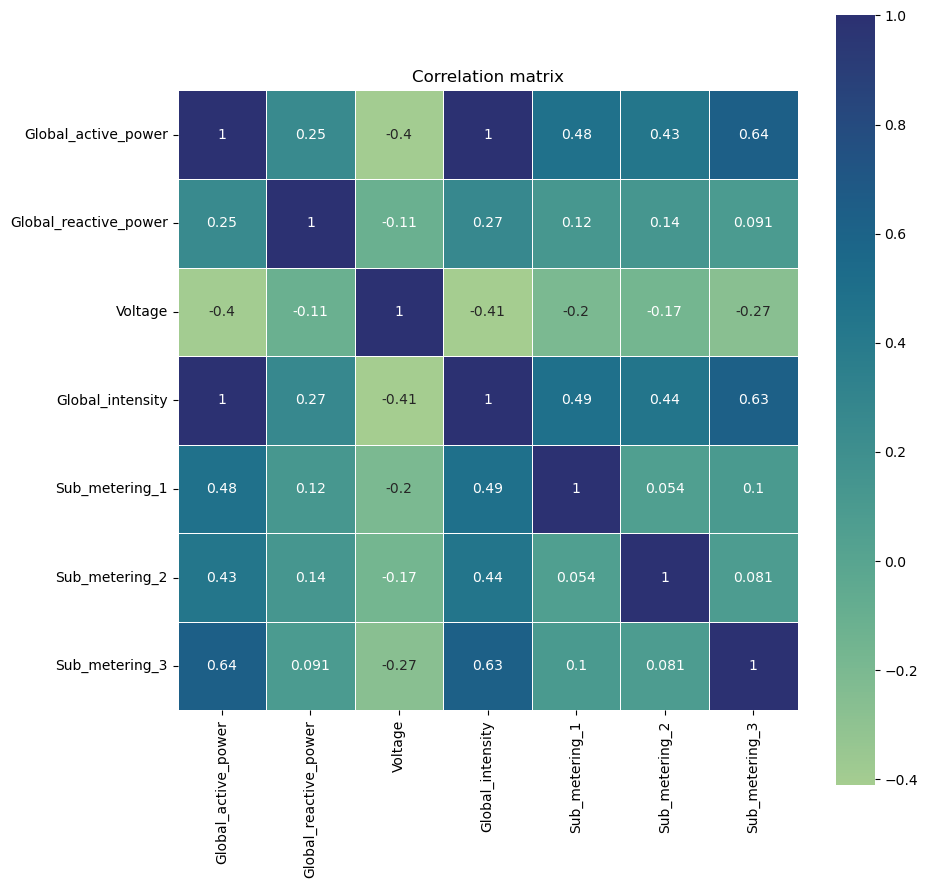

In [18]:
# Correlation (pearson)
pear = df.corr(method='pearson') #, numeric_only=True)

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(pear, annot=True, robust =True, linewidth=.5, square=True, cmap="crest")
plt.title("Correlation matrix");

# fig.savefig('/drive/My Drive/ML_project_files/CorrelationMatrix.png')

In [19]:
# ============================================================= #
# The test takes a very long time - you can comment and skip it #
# ============================================================= #

In [58]:
# Dickey-Fuller test function

def dickey_fuller_test(df):
    print('Test results:')
    df_test = adfuller(df, autolag='AIC')
    df_out = pd.Series(df_test[0:4], index=['Test Statistic','p-value','Lags','Number of observations'])
    for key,value in df_test[4].items():
        df_out['Critical Val (%s)'%key] = value
    print(df_out)
    if df_out['p-value'] < 0.05:
        print("\nSince the p-value is less than 0.05, we can't reject the null hypothesis. ")
        print("This means the time series is stationary type.")
    else:
        print("\nSince the p-value is not less than 0.05, we fail to reject the null hypothesis. ")
        print("This means the time series is non-stationary type.")


# Performing on 1 year time data

dickey_fuller_test(df['ds'][range(950000)])

Test results:
Test Statistic             -168.4089
p-value                       0.0000
Lags                         96.0000
Number of observations   949903.0000
Critical Val (1%)            -3.4304
Critical Val (5%)            -2.8615
Critical Val (10%)           -2.5668
dtype: float64

Since the p-value is less than 0.05, we can't reject the null hypothesis. 
This means the time series is stationary type.


In [20]:
del df['Sub_metering_1']
del df['Sub_metering_2']
del df['Sub_metering_3']
del df['Global_reactive_power']
del df['Voltage']
del df['Global_intensity']

df.rename(columns={'Global_active_power':'y'}, inplace = True)
df.reset_index(inplace=True)

df['y'] = df['y'].apply(lambda x: x/60)

In [21]:
# Doing dataframe with only business hour frequency ('BH')
# monday 2006-12-18 00:00:00 (first monday in DB)
# friday 2010-11-26 21:02:00 (last value in DB)

In [22]:
# ======================== #
# Preparing data for model #
# ======================== #

In [23]:
df_H = df.resample('H', on="ds").mean()
df_H.reset_index(inplace=True)

In [24]:
df_b = df[(df['ds'] >= '2007-01-01 00:00:00') & (df['ds'] < '2010-10-01 00:01:00')]

In [25]:
df_BH = df_b.resample('BH', on='ds').mean()
df_BH.reset_index(inplace=True)
df_BH = df_BH.iloc[1:-1]
df_BH.reset_index(inplace=True)
del df_BH['index']

In [26]:
# ============================================ #
# Train & Test set for business hour frequency #
# ============================================ #

In [27]:
train_BH = df_BH[(df_BH['ds'] >= '2007-01-01 00:00:00') & (df_BH['ds'] < '2010-01-01 00:00:00')]
test_BH = df_BH[(df_BH['ds'] >= '2010-01-01 00:00:00') & (df_BH['ds'] < '2010-10-01 00:00:00')]

In [28]:
# =================== #
# Model & Forecasting #
# =================== #

In [49]:
m_BH = Prophet(seasonality_mode='multiplicative', # for our problem
               growth='flat', # strong seasonality rather trend changes
               interval_width=0.8, # 0.8 is default
               n_changepoints=25,
               changepoint_range=0.01,
               yearly_seasonality='auto',
               weekly_seasonality='auto',
               daily_seasonality=False,
               holidays=None,
               seasonality_prior_scale=1.0,
               holidays_prior_scale=1.0,
               changepoint_prior_scale=0.01,
               mcmc_samples=21 # Uncertainty in seasonality
               )
# m_BH.add_seasonality(name='weekly', period=7, fourier_order=3, mode='multiplicative')
m_BH.fit(train_BH)

future_BH = m_BH.make_future_dataframe(periods=273, freq='D')
forecast_BH = m_BH.predict(future_BH)

13:02:13 - cmdstanpy - INFO - CmdStan installation C:\Users\jaros\AppData\Roaming\Python\Python39\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
13:02:13 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
13:02:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:02:15 - cmdstanpy - INFO - CmdStan done processing.
13:02:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Excep

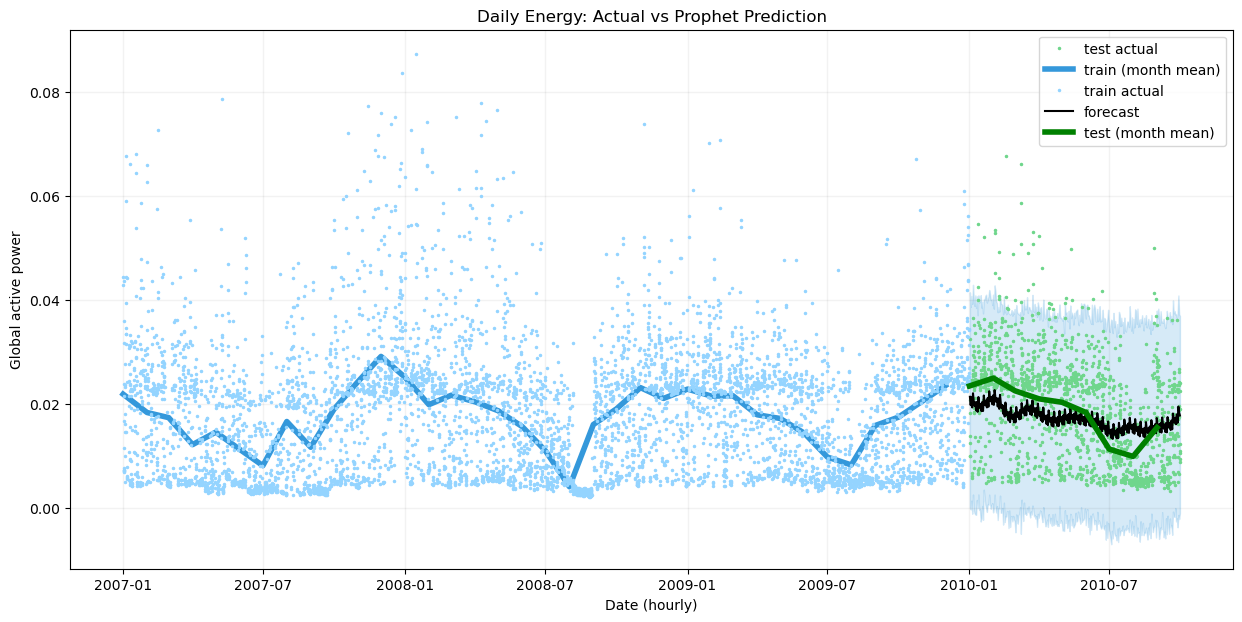

In [31]:
train_BH_mean = train_BH.groupby(train_BH.ds.dt.to_period('M')).mean()
test_BH_mean = test_BH.groupby(test_BH.ds.dt.to_period('M')).mean()
fig = plt.gcf()
fig.set_size_inches(15, 7)
plt.plot(test_BH.ds, test_BH.y, '.', markersize=3, color='#6fd68c', label = "test actual")
plt.plot(train_BH_mean.index.to_timestamp(), train_BH_mean.y, '-', linewidth=4, color='#3498db', label = "train (month mean)")
plt.plot(train_BH.ds, train_BH.y, '.', markersize=3, color='#94d4ff', label = "train actual")
plt.plot(forecast_BH.ds[-273:], forecast_BH.yhat[-273:], color='black', label = "forecast")
plt.plot(test_BH_mean.index.to_timestamp(), test_BH_mean.y, '-', linewidth=4, color='green', label = "test (month mean)")
plt.fill_between(forecast_BH.ds[-273:], forecast_BH.yhat_lower[-273:], forecast_BH.yhat_upper[-273:], color=(52/255, 152/255, 219/255, 0.2))
plt.grid(color=(0, 0, 0), linestyle='-', linewidth=1, alpha=0.05)
plt.ylabel('Global active power')
plt.title('Daily Energy: Actual vs Prophet Prediction')
plt.xlabel('Date (hourly)')
plt.legend()
plt.show()

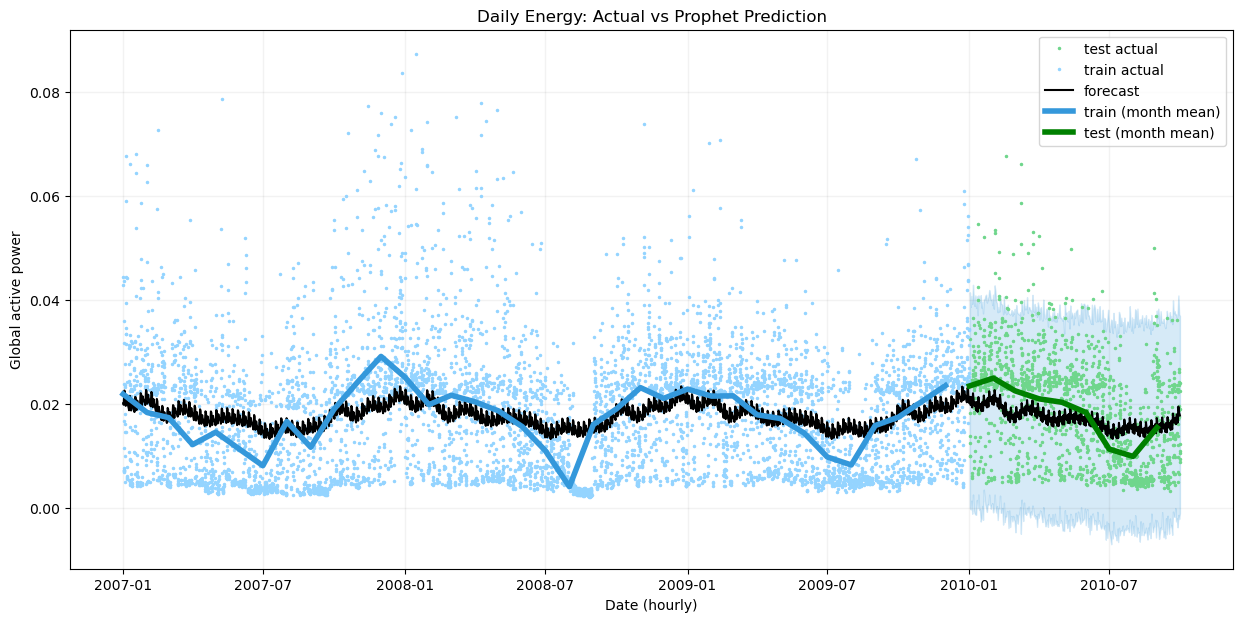

In [32]:
fig = plt.gcf()
fig.set_size_inches(15, 7)
#a = add_changepoints_to_plot(fig.gca(), m_BH, forecast_BH)
plt.plot(test_BH.ds, test_BH.y, '.', markersize=3, color='#6fd68c', label = "test actual")
plt.plot(train_BH.ds, train_BH.y, '.', markersize=3, color='#94d4ff', label = "train actual")
plt.plot(forecast_BH.ds, forecast_BH.yhat, color='black', label = "forecast")
plt.plot(train_BH_mean.index.to_timestamp(), train_BH_mean.y, '-', linewidth=4, color='#3498db', label = "train (month mean)")
plt.plot(test_BH_mean.index.to_timestamp(), test_BH_mean.y, '-', linewidth=4, color='green', label = "test (month mean)")
plt.fill_between(forecast_BH.ds[-273:], forecast_BH.yhat_lower[-273:], forecast_BH.yhat_upper[-273:], color=(52/255, 152/255, 219/255, 0.2))
plt.grid(color=(0, 0, 0), linestyle='-', linewidth=1, alpha=0.05)
plt.ylabel('Global active power')
plt.title('Daily Energy: Actual vs Prophet Prediction')
plt.xlabel('Date (hourly)')
plt.legend()
plt.show()

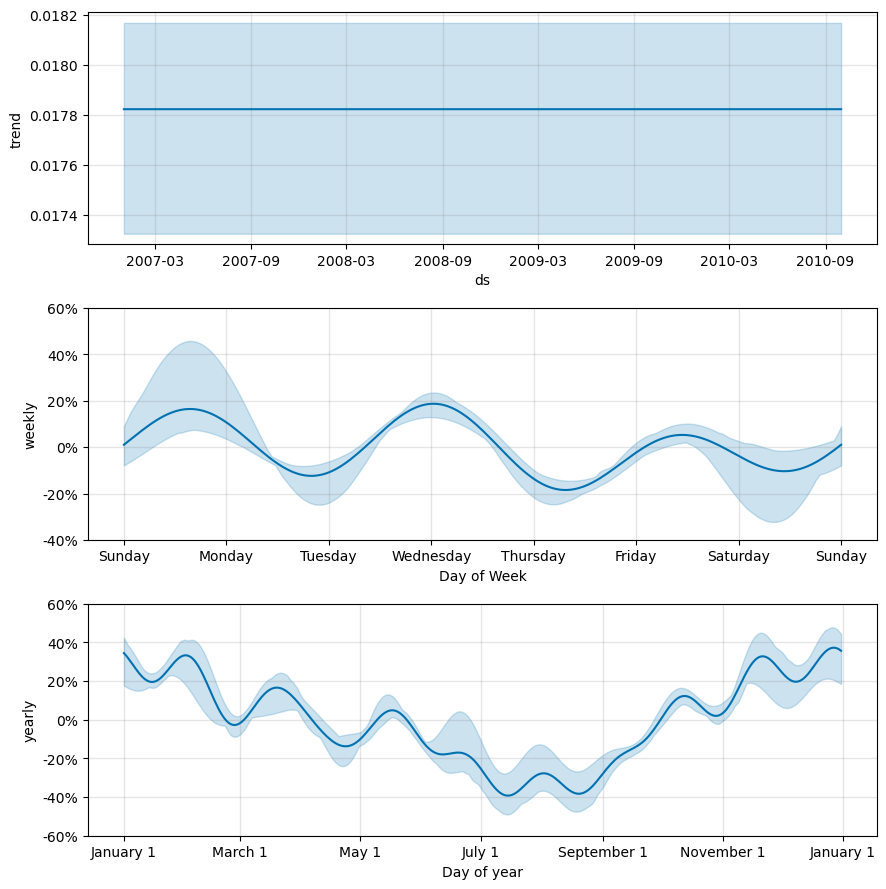

In [50]:
fig = m_BH.plot_components(forecast_BH)

In [51]:
# ========================= #
# Below:                    #
# For standard Hour         #
# Plus special 'multi-plot' #
# ========================= #

In [52]:
train_H = df_H

In [53]:
train_H = df_H[(df_H['ds'] >= '2007-01-01 00:00:00') & (df_H['ds'] < '2010-01-01 00:01:00')]
test_H = df_H[(df_H['ds'] >= '2010-01-01 00:00:00') & (df_H['ds'] < '2010-10-01 00:00:00')]

In [54]:
train_H = train_H.iloc[:-1]
train_H.reset_index(inplace=True)
del train_H['index']

In [55]:
#    interval_width=0.8,
#    n_changepoints=25,
#    changepoint_range=0.8,
#    yearly_seasonality='auto',
#    weekly_seasonality='auto',
#    daily_seasonality=False,
#    holidays=None,
#    seasonality_prior_scale=10.0,
#    holidays_prior_scale=10.0,
#    changepoint_prior_scale=0.05,
#    mcmc_samples=25

In [56]:
m_H = Prophet(seasonality_mode='multiplicative', # for our problem
               growth='flat', # strong seasonality rather trend changes
               interval_width=0.8, # 0.8 is default
               n_changepoints=25,
               changepoint_range=0.01,
               yearly_seasonality='auto',
               weekly_seasonality='auto',
               daily_seasonality=False,
               holidays=None,
               seasonality_prior_scale=1.0,
               holidays_prior_scale=1.0,
               changepoint_prior_scale=0.01,
               mcmc_samples=21 # Uncertainty in seasonality
               )
# m_H.add_seasonality(name='weekly', period=7, fourier_order=2, mode='multiplicative')
m_H.fit(train_H)

future_H = m_H.make_future_dataframe(periods=273, freq='D')
forecast_H = m_H.predict(future_H)

13:03:40 - cmdstanpy - INFO - CmdStan installation C:\Users\jaros\AppData\Roaming\Python\Python39\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
13:03:40 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
13:03:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:03:44 - cmdstanpy - INFO - CmdStan done processing.
13:03:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exce

13:03:44 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 10 divergent transitions (100.0%)
	Chain 2 had 10 divergent transitions (100.0%)
	Chain 3 had 10 divergent transitions (100.0%)
	Chain 4 had 10 divergent transitions (100.0%)
	Use function "diagnose()" to see further information.


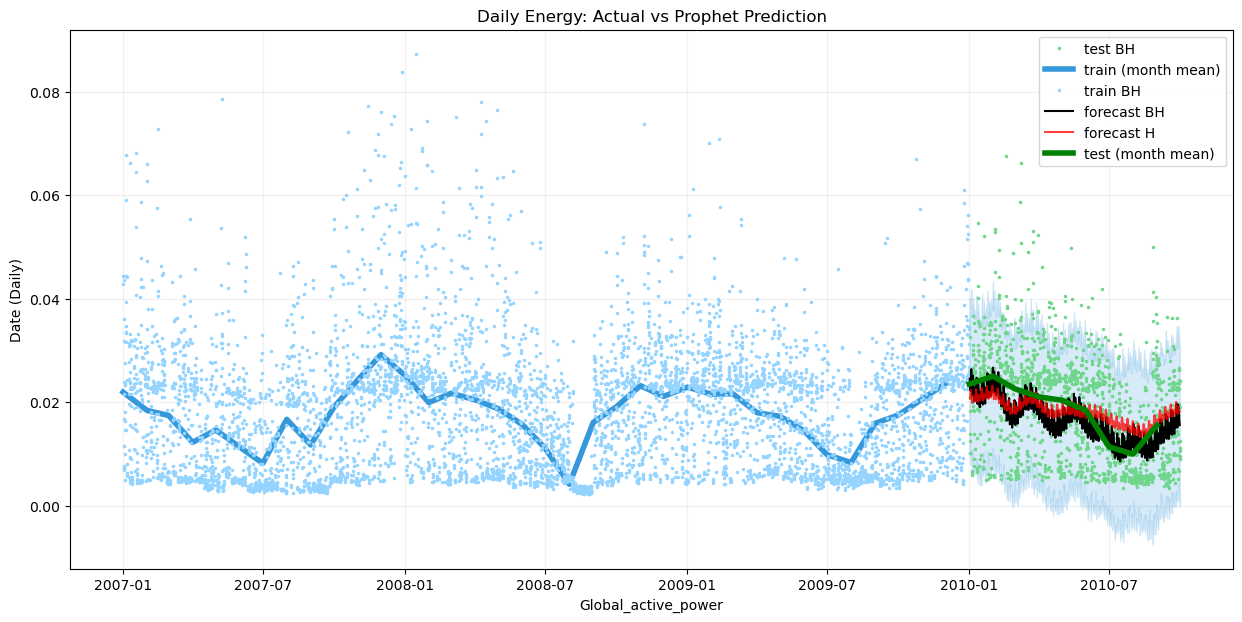

In [57]:
fig = plt.gcf()
fig.set_size_inches(15, 7)
plt.plot(test_BH.ds, test_BH.y, '.', markersize=3, color='#6fd68c', label = "test BH")
plt.plot(train_BH_mean.index.to_timestamp(), train_BH_mean.y, '-', linewidth=4, color='#3498db', label = "train (month mean)")
plt.plot(train_BH.ds, train_BH.y, '.', markersize=3, color='#94d4ff', label = "train BH")
plt.plot(forecast_BH.ds[-273:], forecast_BH.yhat[-273:], color='black', label = "forecast BH")
plt.plot(forecast_H.ds[-273:], forecast_H.yhat[-273:], color='red', label = "forecast H", alpha=0.75)
plt.plot(test_BH_mean.index.to_timestamp(), test_BH_mean.y, '-', linewidth=4, color='green', label = "test (month mean)")
plt.fill_between(forecast_BH.ds[-273:], forecast_BH.yhat_lower[-273:], forecast_BH.yhat_upper[-273:], color=(52/255, 152/255, 219/255, 0.2))
plt.grid(color=(0, 0, 0), linestyle='-', linewidth=1, alpha=0.05)
plt.xlabel('Global_active_power')
plt.title('Daily Energy: Actual vs Prophet Prediction')
plt.ylabel('Date (Daily)')
plt.legend()
plt.show()

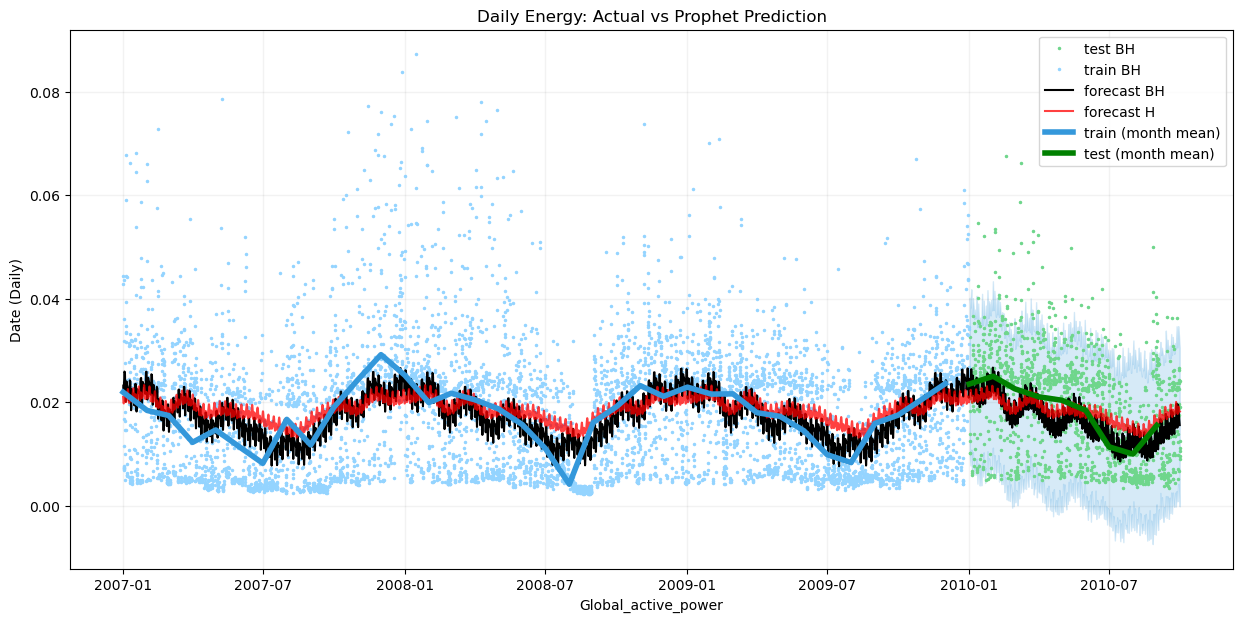

In [58]:
fig = plt.gcf()
fig.set_size_inches(15, 7)
plt.plot(test_BH.ds, test_BH.y, '.', markersize=3, color='#6fd68c', label = "test BH")
plt.plot(train_BH.ds, train_BH.y, '.', markersize=3, color='#94d4ff', label = "train BH")
plt.plot(forecast_BH.ds, forecast_BH.yhat, color='black', label = "forecast BH", alpha=1.0)
plt.plot(forecast_H.ds, forecast_H.yhat, color='red', label = "forecast H", alpha=0.75)
plt.plot(train_BH_mean.index.to_timestamp(), train_BH_mean.y, '-', linewidth=4, color='#3498db', label = "train (month mean)")
plt.plot(test_BH_mean.index.to_timestamp(), test_BH_mean.y, '-', linewidth=4, color='green', label = "test (month mean)")
plt.fill_between(forecast_BH.ds[-273:], forecast_BH.yhat_lower[-273:], forecast_BH.yhat_upper[-273:], color=(52/255, 152/255, 219/255, 0.2))
plt.grid(color=(0, 0, 0), linestyle='-', linewidth=1, alpha=0.05)
plt.xlabel('Global_active_power')
plt.title('Daily Energy: Actual vs Prophet Prediction')
plt.ylabel('Date (Daily)')
plt.legend()
plt.show()

For business hour
For all hour


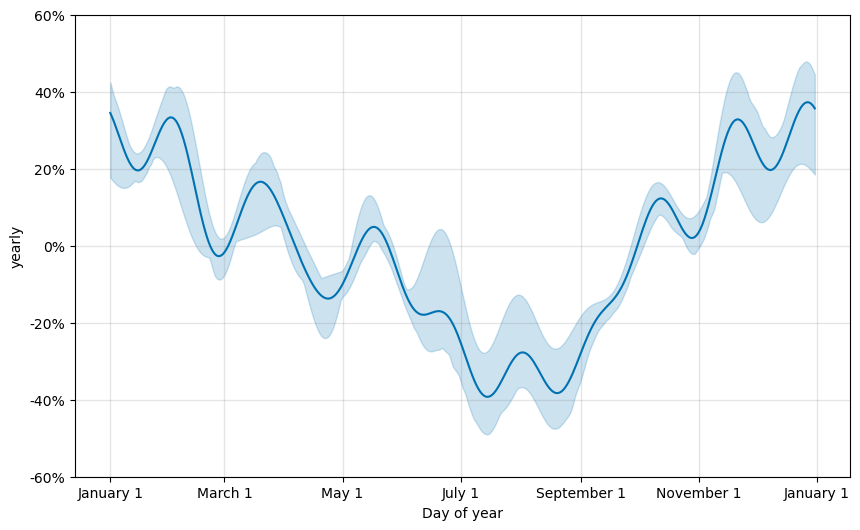

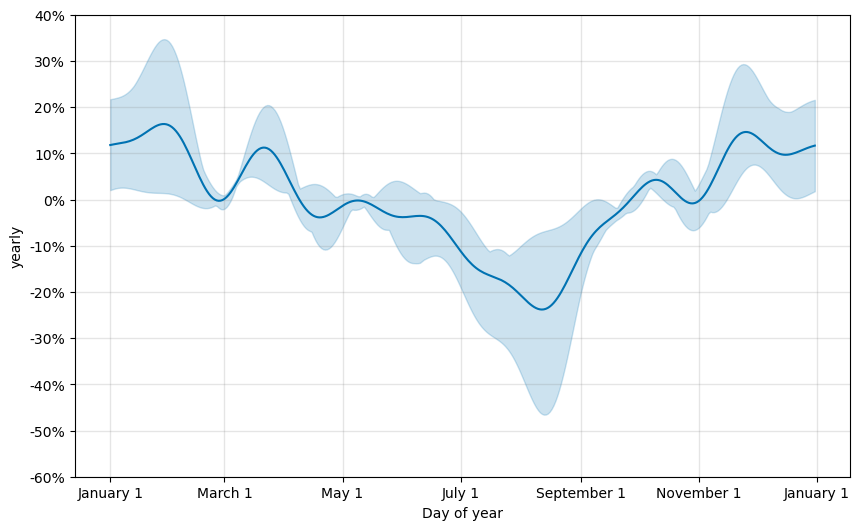

In [77]:
print('For business hour')
plot_yearly(m_BH, name='yearly');
print('For all hour')
plot_yearly(m_H, name='yearly');

In [78]:
# cutoffs = pd.to_datetime(['2010-02-15', '2010-08-15', '2010-02-15'])
df_cv_BH = cross_validation(m_BH,
                            #cutoffs=cutoffs,
                            initial='540 days',
                            period='30 days',
                            horizon='90 days',
                            parallel='processes')
df_cv_BH_p = performance_metrics(df_cv_BH)
df_cv_BH_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days 17:00:00,0.0001,0.0098,0.0079,0.8189,0.4016,0.5308,0.9020
1,9 days 18:00:00,0.0001,0.0098,0.0079,0.8250,0.4031,0.5314,0.9020
2,9 days 19:00:00,0.0001,0.0098,0.0079,0.8305,0.4031,0.5312,0.9027
3,9 days 20:00:00,0.0001,0.0099,0.0079,0.8362,0.4079,0.5331,0.9015
4,9 days 21:00:00,0.0001,0.0099,0.0080,0.8484,0.4105,0.5363,0.9020


In [79]:
# cutoffs = pd.to_datetime(['2010-02-15', '2010-08-15', '2010-02-15'])
df_cv_H = cross_validation(m_H,
                            #cutoffs=cutoffs,
                            initial='540 days',
                            period='30 days',
                            horizon='90 days',
                            parallel='processes')
df_cv_H_p = performance_metrics(df_cv_H)
df_cv_H_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days 00:00:00,0.0002,0.0131,0.0107,1.1794,0.6287,0.6726,0.9120
1,9 days 01:00:00,0.0002,0.0132,0.0107,1.1802,0.6287,0.6730,0.9120
2,9 days 02:00:00,0.0002,0.0132,0.0108,1.1827,0.6298,0.6737,0.9120
3,9 days 03:00:00,0.0002,0.0132,0.0108,1.1829,0.6297,0.6736,0.9126
4,9 days 04:00:00,0.0002,0.0132,0.0108,1.1838,0.6294,0.6737,0.9129


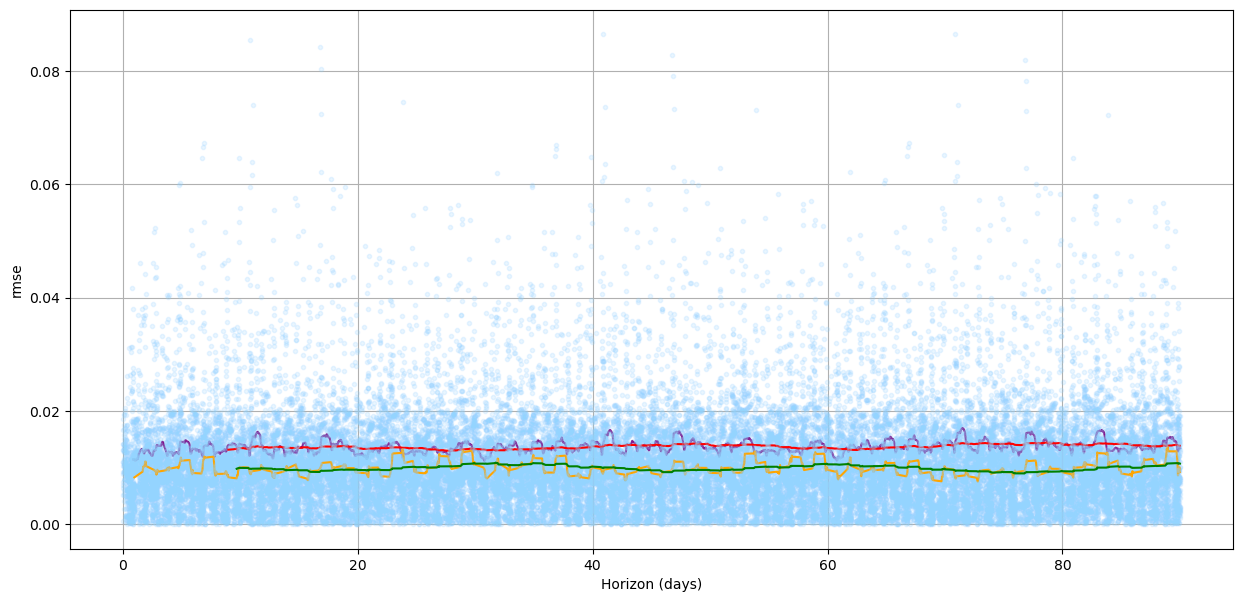

In [80]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
plot_cross_validation_metric(df_cv_H,
                             metric='rmse',
                             rolling_window=0.01,
                             color='purple',
                             point_color='#94d4ff',
                             ax=ax)
plot_cross_validation_metric(df_cv_H,
                             metric='rmse',
                             rolling_window=0.1,
                             color='red',
                             point_color='#94d4ff',
                             ax=ax)
plot_cross_validation_metric(df_cv_BH,
                             metric='rmse',
                             rolling_window=0.01,
                             color='orange',
                             point_color='#94d4ff',
                             ax=ax)
plot_cross_validation_metric(df_cv_BH,
                             metric='rmse',
                             rolling_window=0.1,
                             color='green',
                             point_color='#94d4ff',
                             ax=ax)
plt.show()

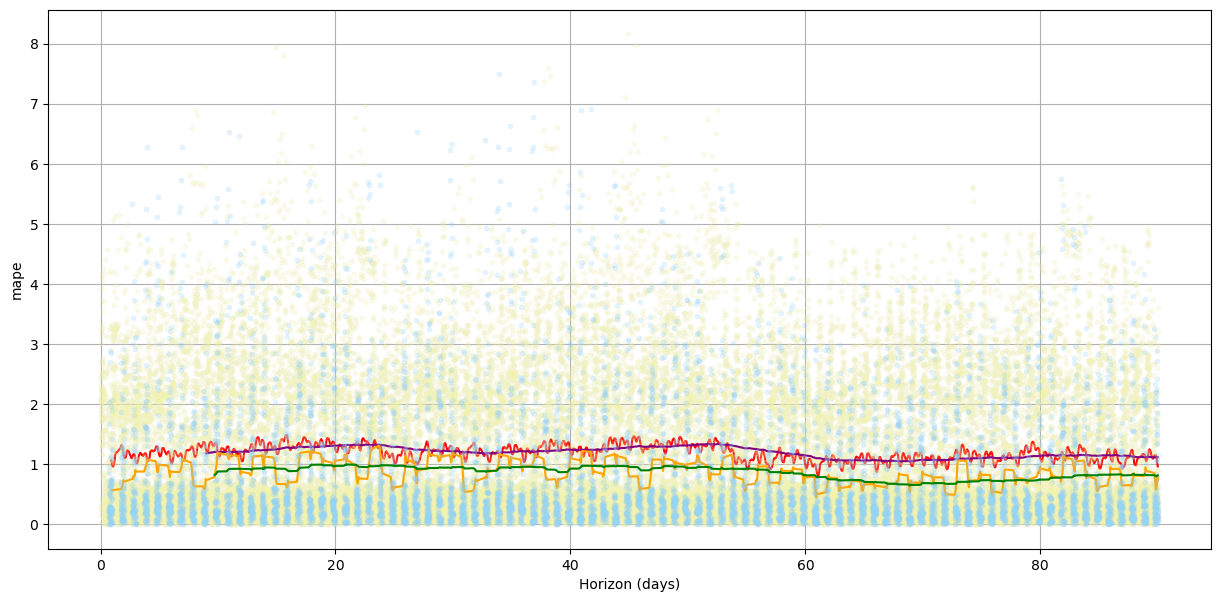

In [81]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
plot_cross_validation_metric(df_cv_H,
                             metric='mape',
                             rolling_window=0.01,
                             color='red',
                             point_color='#f1f2ae',
                             ax=ax)
plot_cross_validation_metric(df_cv_H,
                             metric='mape',
                             rolling_window=0.1,
                             color='purple',
                             point_color='#f1f2ae',
                             ax=ax)
plot_cross_validation_metric(df_cv_BH,
                             metric='mape',
                             rolling_window=0.01,
                             color='orange',
                             point_color='#94d4ff',
                             ax=ax)
plot_cross_validation_metric(df_cv_BH,
                             metric='mape',
                             rolling_window=0.1,
                             color='green',
                             point_color='#94d4ff',
                             ax=ax)
plt.show()

In [39]:
# ===================== #
# Hyperparameter Tuning #
# ===================== #

In [42]:
param_grid = {  
    'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 5.0, 10.0],
    'holidays_prior_scale' : [0.01, 0.1, 1.0, 5.0, 10.0],
    'changepoint_range': [0.01, 0.05, 0.1, 0.5, 0.8, 0.85, 0.9, 0.95]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mses = []
rmses = []  
maes = []
mapes = []
mdapes = []
smapes = []

# Use cross validation to evaluate all parameters
for params in all_params:
    model_BH = Prophet(**params, daily_seasonality=False, growth='flat')  # Fit model with given params
    model_BH.add_country_holidays(country_name='FRA')
    model_BH.add_seasonality(name='weekly', period=5, fourier_order=3, mode='multiplicative')
    model_BH.fit(train_BH)
    bh_cv = cross_validation(model_BH,
                             #cutoffs=cutoffs,
                             horizon='90 days',
                             period='30 days',
                             initial='540 days',
                             parallel='processes')
    bh_cv_pm = performance_metrics(bh_cv, rolling_window=1)
    mses.append(bh_cv_pm['mse'].values[0])
    rmses.append(bh_cv_pm['rmse'].values[0])
    maes.append(bh_cv_pm['mae'].values[0])
    mapes.append(bh_cv_pm['mape'].values[0])
    mdapes.append(bh_cv_pm['mdape'].values[0])
    smapes.append(bh_cv_pm['smape'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mse'] = mses
tuning_results['rmse'] = rmses
tuning_results['mae'] = maes
tuning_results['mape'] = mapes
tuning_results['mdape'] = mdapes
tuning_results['smape'] = smapes
print(tuning_results)

21:40:51 - cmdstanpy - INFO - Chain [1] start processing
21:40:51 - cmdstanpy - INFO - Chain [1] done processing
21:41:11 - cmdstanpy - INFO - Chain [1] start processing
21:41:12 - cmdstanpy - INFO - Chain [1] done processing
21:41:32 - cmdstanpy - INFO - Chain [1] start processing
21:41:32 - cmdstanpy - INFO - Chain [1] done processing
21:41:56 - cmdstanpy - INFO - Chain [1] start processing
21:41:56 - cmdstanpy - INFO - Chain [1] done processing
21:42:22 - cmdstanpy - INFO - Chain [1] start processing
21:42:22 - cmdstanpy - INFO - Chain [1] done processing
21:42:54 - cmdstanpy - INFO - Chain [1] start processing
21:42:55 - cmdstanpy - INFO - Chain [1] done processing
21:43:21 - cmdstanpy - INFO - Chain [1] start processing
21:43:22 - cmdstanpy - INFO - Chain [1] done processing
21:43:43 - cmdstanpy - INFO - Chain [1] start processing
21:43:43 - cmdstanpy - INFO - Chain [1] done processing
21:44:06 - cmdstanpy - INFO - Chain [1] start processing
21:44:06 - cmdstanpy - INFO - Chain [1]

     changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                      0.010                    0.010                 0.010   
1                      0.010                    0.010                 0.010   
2                      0.010                    0.010                 0.010   
3                      0.010                    0.010                 0.010   
4                      0.010                    0.010                 0.010   
..                       ...                      ...                   ...   
795                    0.500                   10.000                10.000   
796                    0.500                   10.000                10.000   
797                    0.500                   10.000                10.000   
798                    0.500                   10.000                10.000   
799                    0.500                   10.000                10.000   

     changepoint_range   mse  rmse   mae  mape  mda

In [56]:
bh_cv.to_pickle("bh_cv.pkl")

In [54]:
tuning_results

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,changepoint_range,mse,rmse,mae,mape,mdape,smape
0,0.0100,0.0100,0.0100,0.0100,0.0001,0.0099,0.0079,0.8439,0.4010,0.5139
1,0.0100,0.0100,0.0100,0.0500,0.0001,0.0099,0.0079,0.8439,0.4010,0.5139
2,0.0100,0.0100,0.0100,0.1000,0.0001,0.0099,0.0079,0.8439,0.4010,0.5139
3,0.0100,0.0100,0.0100,0.5000,0.0001,0.0099,0.0079,0.8439,0.4010,0.5139
4,0.0100,0.0100,0.0100,0.8000,0.0001,0.0099,0.0079,0.8439,0.4010,0.5139
...,...,...,...,...,...,...,...,...,...,...
795,0.5000,10.0000,10.0000,0.5000,0.0001,0.0101,0.0080,0.8424,0.4068,0.5155
796,0.5000,10.0000,10.0000,0.8000,0.0001,0.0101,0.0080,0.8424,0.4068,0.5155
797,0.5000,10.0000,10.0000,0.8500,0.0001,0.0101,0.0080,0.8424,0.4068,0.5155
798,0.5000,10.0000,10.0000,0.9000,0.0001,0.0101,0.0080,0.8424,0.4068,0.5155


In [57]:
tuning_results.to_csv('tuning_results.csv', index=False)

In [55]:
bh_cv_pm

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,90 days,0.0001,0.0101,0.0080,0.8424,0.4068,0.5155,0.8818


In [72]:
best_params1 = all_params[np.argmin('mse')]
print('Best mse: ', best_params1)
best_params2 = all_params[np.argmin('rmse')]
print('Best rmse: ', best_params2)
best_params3 = all_params[np.argmax('mae')]
print('Best mae: ', best_params3)
best_params4 = all_params[np.argmax('mape')]
print('Best mape: ', best_params4)
best_params5 = all_params[np.argmax('mdape')]
print('Best mdape: ', best_params5)
best_params6 = all_params[np.argmax('smape')]
print('Best smape: ', best_params6)

Best mse:  {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'changepoint_range': 0.01}
Best rmse:  {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'changepoint_range': 0.01}
Best mae:  {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'changepoint_range': 0.01}
Best mape:  {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'changepoint_range': 0.01}
Best mdape:  {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'changepoint_range': 0.01}
Best smape:  {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'changepoint_range': 0.01}


In [85]:
m_BH = Prophet(seasonality_mode='multiplicative',
               growth='flat',
               interval_width=0.8,
               n_changepoints=25,
               changepoint_range=0.01,
               yearly_seasonality='auto',
               weekly_seasonality='auto',
               daily_seasonality=False,
               holidays=None,
               seasonality_prior_scale=0.01,
               holidays_prior_scale=0.01,
               changepoint_prior_scale=0.01,
               mcmc_samples=25)
m_BH.add_country_holidays(country_name='FRA')
m_BH.add_seasonality(name='weekly', period=5, fourier_order=3, mode='multiplicative')
m_BH.fit(train_BH)

future_BH = m_BH.make_future_dataframe(periods=546, freq='D')
forecast_BH = m_BH.predict(future_BH)

11:43:13 - cmdstanpy - INFO - CmdStan installation C:\Users\jaros\AppData\Roaming\Python\Python39\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
11:43:13 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
11:43:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:43:15 - cmdstanpy - INFO - CmdStan done processing.
11:43:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Excep

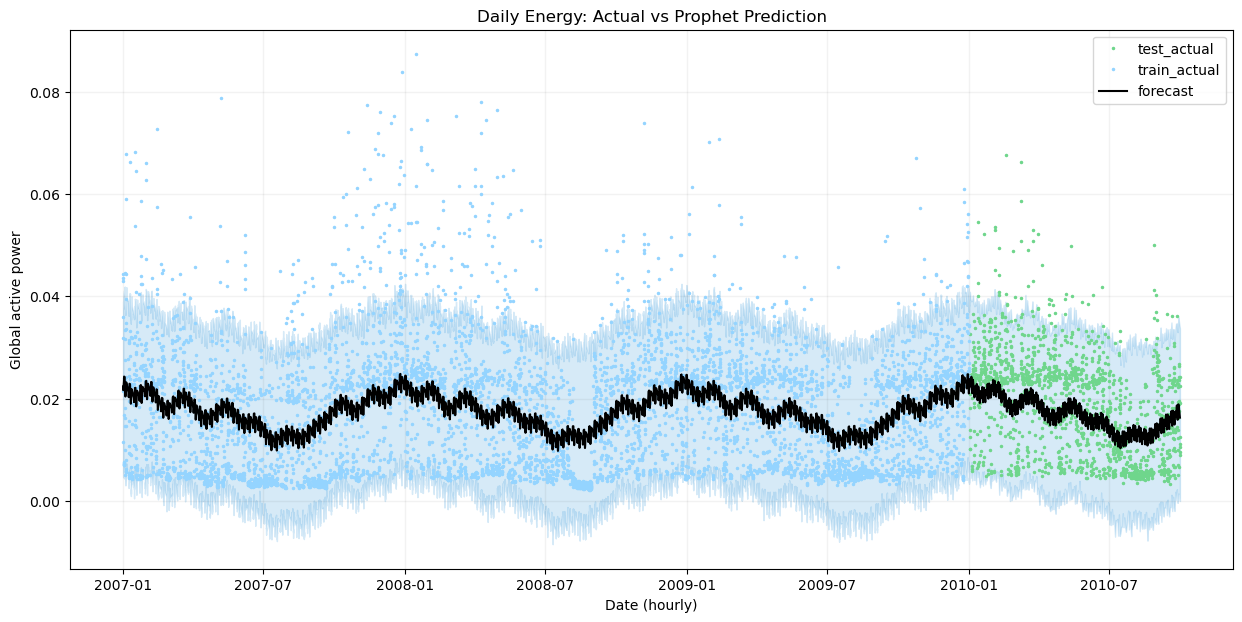

In [528]:
fig = plt.gcf()
fig.set_size_inches(15, 7)
#a = add_changepoints_to_plot(fig.gca(), m_BH, forecast_BH)
plt.plot(test_BH.ds, test_BH.y, '.', markersize=3, color='#6fd68c', label = "test_actual")
plt.plot(train_BH.ds, train_BH.y, '.', markersize=3, color='#94d4ff', label = "train_actual")
plt.plot(forecast_BH.ds, forecast_BH.yhat, color='black', label = "forecast")
plt.fill_between(forecast_BH.ds, forecast_BH.yhat_lower, forecast_BH.yhat_upper, color=(52/255, 152/255, 219/255, 0.2))
plt.grid(color=(0, 0, 0), linestyle='-', linewidth=1, alpha=0.05)
plt.ylabel('Global active power')
plt.title('Daily Energy: Actual vs Prophet Prediction')
plt.xlabel('Date (hourly)')
plt.legend()
plt.show()

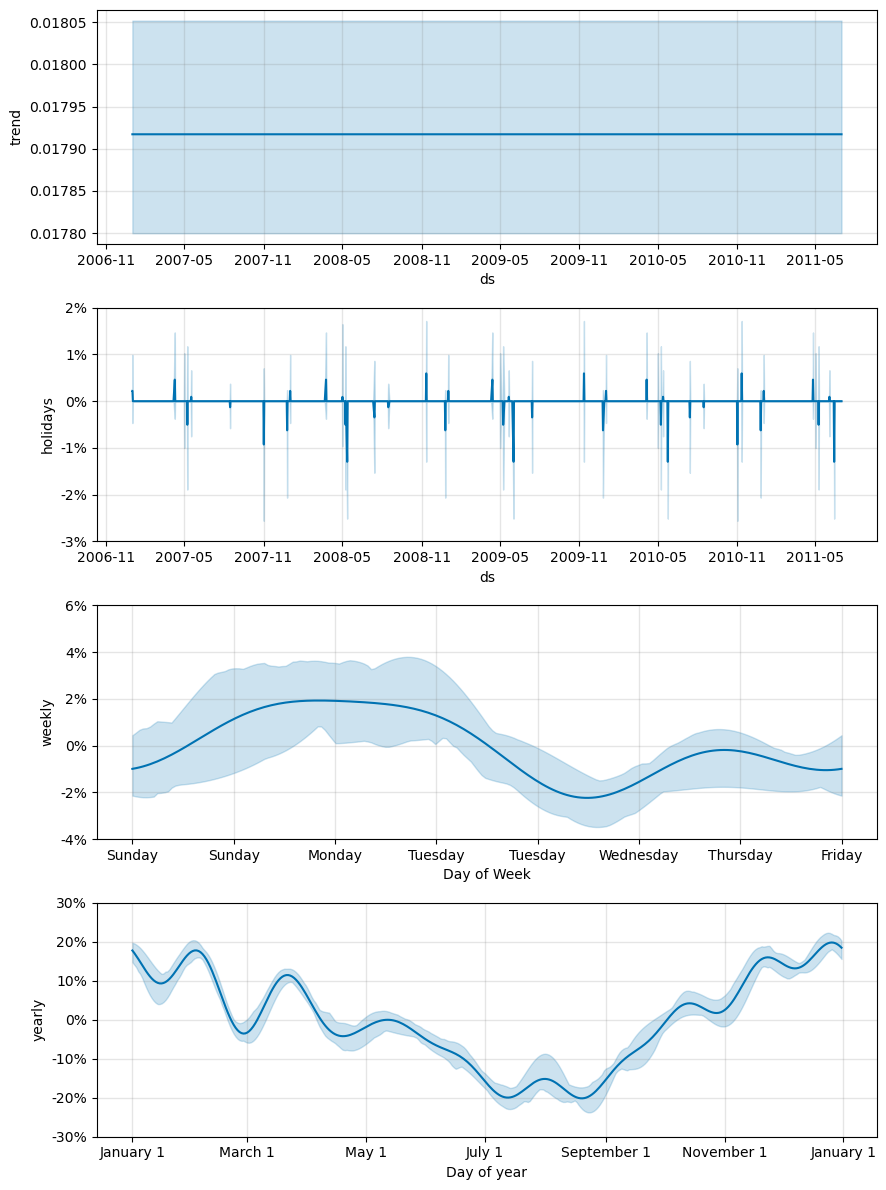

In [87]:
fig = m_BH.plot_components(forecast_BH)

In [88]:
train_H = df_H
train_H = df_H[(df_H['ds'] >= '2007-01-01 00:00:00') & (df_H['ds'] < '2010-10-01 00:01:00')]

train_H = train_H.iloc[:-1]
train_H.reset_index(inplace=True)
del train_H['index']

In [89]:
m_H = Prophet(seasonality_mode='multiplicative',
               growth='flat', 
               interval_width=0.8,
               n_changepoints=25,
               changepoint_range=0.01,
               yearly_seasonality='auto',
               weekly_seasonality='auto',
               daily_seasonality=False,
               holidays=None,
               seasonality_prior_scale=0.01,
               holidays_prior_scale=0.01,
               changepoint_prior_scale=0.01,
               mcmc_samples=25
               ) 
m_H.add_country_holidays(country_name='FRA')
m_H.add_seasonality(name='weekly', period=7, fourier_order=3, mode='multiplicative')
m_H.fit(train_H)

future_H = m_H.make_future_dataframe(periods=273, freq='D')
forecast_H = m_H.predict(future_H)

11:43:58 - cmdstanpy - INFO - CmdStan installation C:\Users\jaros\AppData\Roaming\Python\Python39\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
11:43:58 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
11:43:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:44:04 - cmdstanpy - INFO - CmdStan done processing.
11:44:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exce

11:44:04 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 11 divergent transitions (91.7%)
	Chain 2 had 10 divergent transitions (83.3%)
	Chain 3 had 12 divergent transitions (100.0%)
	Chain 4 had 12 divergent transitions (100.0%)
	Use function "diagnose()" to see further information.


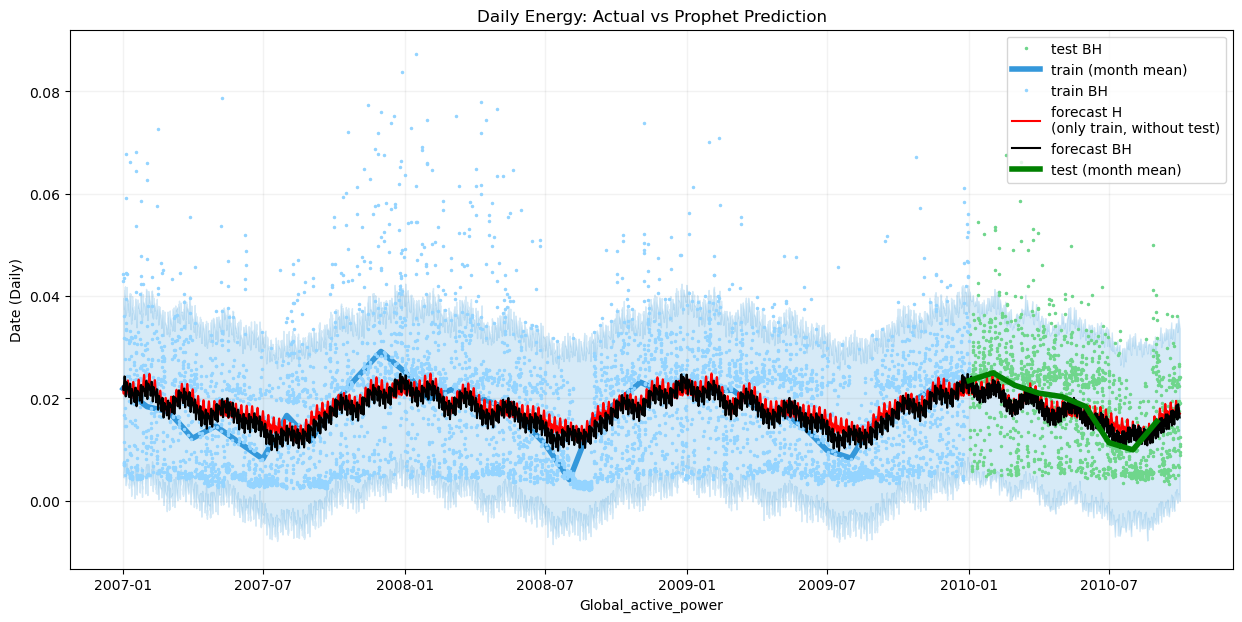

In [535]:
fig = plt.gcf()
fig.set_size_inches(15, 7)
#plt.fill_between(forecast_H['ds'][forecast_H['ds'] >= '2010-11-19'], forecast_BH.yhat, forecast_H.yhat, color=(252/255, 252/255, 219/255, 0.2))
plt.plot(test_BH.ds, test_BH.y, '.', markersize=3, color='#6fd68c', label = "test BH")
plt.plot(train_BH_mean.index.to_timestamp(), train_BH_mean.y, '-', linewidth=4, color='#3498db', label = "train (month mean)")
plt.plot(train_BH.ds, train_BH.y, '.', markersize=3, color='#94d4ff', label = "train BH")
plt.plot(forecast_H.ds, forecast_H.yhat, color='red', label = "forecast H\n(only train, without test)")
plt.plot(forecast_BH.ds, forecast_BH.yhat, color='black', label = "forecast BH")
plt.plot(test_BH_mean.index.to_timestamp(), test_BH_mean.y, '-', linewidth=4, color='green', label = "test (month mean)")
plt.fill_between(forecast_BH.ds, forecast_BH.yhat_lower, forecast_BH.yhat_upper, color=(52/255, 152/255, 219/255, 0.2))
plt.grid(color=(0, 0, 0), linestyle='-', linewidth=1, alpha=0.05)
plt.xlabel('Global_active_power')
plt.title('Daily Energy: Actual vs Prophet Prediction')
plt.ylabel('Date (Daily)')
plt.legend()
plt.show()

In [ ]:
# ======================= #
# Holidays in seasonality #
# ======================= #

In [556]:
m_holidays = Prophet(seasonality_mode='multiplicative', # for our problem
               growth='flat',
               interval_width=0.8, # 0.8 is default (experimenting)
               n_changepoints=25,
               changepoint_range = 0.8,
               changepoint_prior_scale=0.05,
               holidays_prior_scale=10.0,
               seasonality_prior_scale=10.0,
               holidays=None,
               daily_seasonality=False,
               yearly_seasonality='auto',
               weekly_seasonality='auto',
               mcmc_samples=21
               ) # Uncertainty in seasonality (instead interval_width parameter)

m_holidays.add_country_holidays(country_name='FRA')
m_holidays.add_seasonality(name='weekly', period=7, fourier_order=3, mode='multiplicative')
m_holidays.fit(train_H)

future_holidays = m_holidays.make_future_dataframe(periods=273, freq='D')

forecast_holidays = m_holidays.predict(future_holidays)

00:58:22 - cmdstanpy - INFO - CmdStan installation C:\Users\jaros\AppData\Roaming\Python\Python39\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
00:58:22 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
00:58:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

00:58:26 - cmdstanpy - INFO - CmdStan done processing.
00:58:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exce

00:58:26 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 10 divergent transitions (100.0%)
	Chain 2 had 10 divergent transitions (100.0%)
	Chain 3 had 10 divergent transitions (100.0%)
	Chain 4 had 10 divergent transitions (100.0%)
	Use function "diagnose()" to see further information.


In [516]:
m_holidays.train_holiday_names

0            Jour de l'an
1               Ascension
2         Fête du Travail
3     Fête de la Victoire
4          Fête nationale
5               Armistice
6         Lundi de Pâques
7      Lundi de Pentecôte
8              Assomption
9               Toussaint
10                   Noël
dtype: object

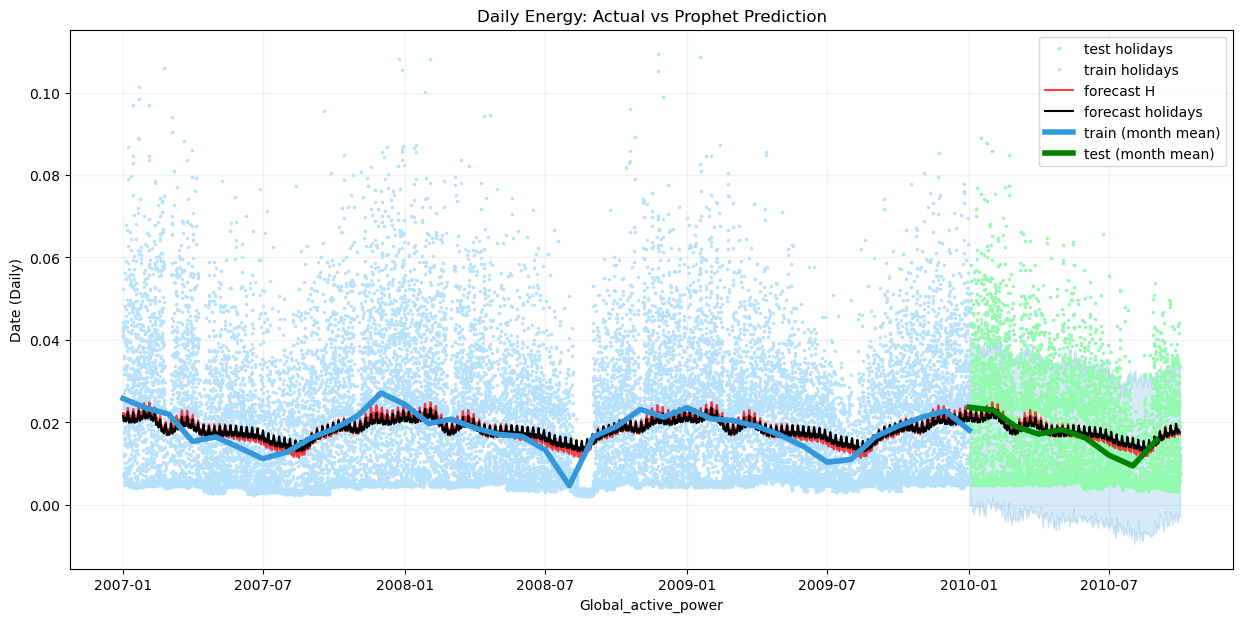

In [557]:
train_H_mean = train_H.groupby(train_H.ds.dt.to_period('M')).mean()
test_H_mean = test_H.groupby(test_H.ds.dt.to_period('M')).mean()

fig = plt.gcf()
fig.set_size_inches(15, 7)
plt.plot(test_H.ds, test_H.y, '.', markersize=3, color='#93fab0', label = "test holidays")
plt.plot(train_H.ds, train_H.y, '.', markersize=3, color='#b8e1fc', label = "train holidays")
plt.plot(forecast_H.ds, forecast_H.yhat, color='red', label = "forecast H", alpha=0.75)
plt.plot(forecast_holidays.ds, forecast_holidays.yhat, color='black', label = "forecast holidays", alpha=1.0)
plt.plot(train_H_mean.index.to_timestamp(), train_H_mean.y, '-', linewidth=4, color='#3498db', label = "train (month mean)")
plt.plot(test_H_mean.index.to_timestamp(), test_H_mean.y, '-', linewidth=4, color='green', label = "test (month mean)")
plt.fill_between(forecast_holidays.ds[-273:], forecast_holidays.yhat_lower[-273:], forecast_BH.yhat_upper[-273:], color=(52/255, 152/255, 219/255, 0.2))
plt.grid(color=(0, 0, 0), linestyle='-', linewidth=1, alpha=0.05)
plt.xlabel('Global_active_power')
plt.title('Daily Energy: Actual vs Prophet Prediction')
plt.ylabel('Date (Daily)')
plt.legend()
plt.show()

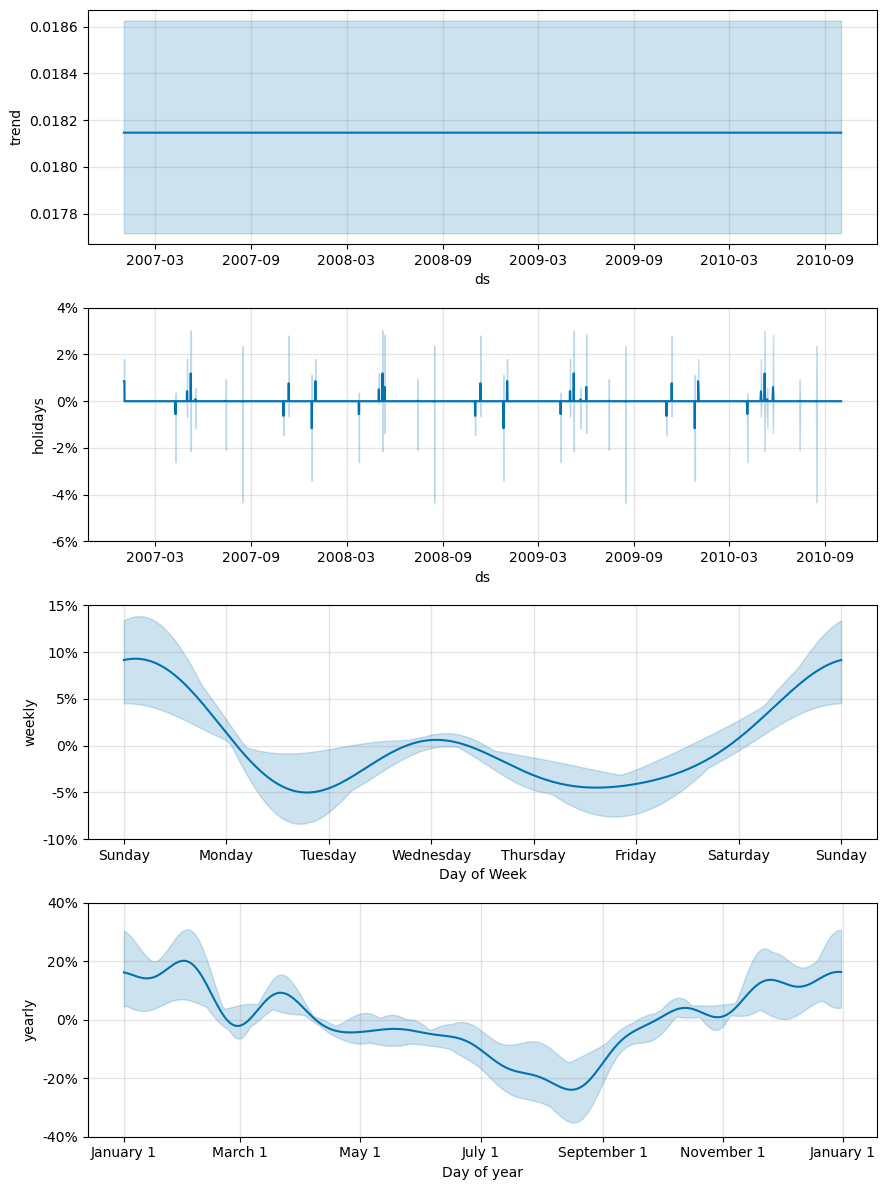

In [558]:
fig = m_holidays.plot_components(forecast_holidays)

In [ ]:
fig = m_holidays.plot(forecast_holidays)

In [ ]:
# =================================== #
# Strange experimental things below   #
# =================================== #

In [ ]:
# Prophet() parameters:
# growth='flat' (strong seasonality patterns rather trend changes)
# interval_width=0.95 (width of the uncertainty intervals provided for the forecast)
# 
# changepoints	
# Vector of dates at which to include potential changepoints. If not specified, potential changepoints are selected automatically.
#
# n.changepoints	
# Number of potential changepoints to include. Not used if input 'changepoints' is supplied. If 'changepoints' is not supplied, then n.changepoints potential changepoints are selected uniformly from the first 'changepoint.range' proportion of df.ds.
#
# changepoint.range	
# Proportion of history in which trend changepoints will be estimated. Defaults to 0.8 for the first 80 'changepoints' is specified.
#
# yearly.seasonality	
# Fit yearly seasonality. Can be 'auto', TRUE, FALSE, or a number of Fourier terms to generate.
#
# weekly.seasonality	
# Fit weekly seasonality. Can be 'auto', TRUE, FALSE, or a number of Fourier terms to generate.
#
# daily.seasonality	
# Fit daily seasonality. Can be 'auto', TRUE, FALSE, or a number of Fourier terms to generate.
#
# holidays	
# data frame with columns holiday (character) and ds (date type)and optionally columns lower_window and upper_window which specify a range of days around the date to be included as holidays. lower_window=-2 will include 2 days prior to the date as holidays. Also optionally can have a column prior_scale specifying the prior scale for each holiday.
#
# seasonality.mode	
# 'additive' (default) or 'multiplicative'.
#
# seasonality.prior.scale	
# Parameter modulating the strength of the seasonality model. Larger values allow the model to fit larger seasonal fluctuations, smaller values dampen the seasonality. Can be specified for individual seasonalities using add_seasonality.
#
# holidays.prior.scale	
# Parameter modulating the strength of the holiday components model, unless overridden in the holidays input.
#
# changepoint.prior.scale	
# Parameter modulating the flexibility of the automatic changepoint selection. Large values will allow many changepoints, small values will allow few changepoints.
#
# mcmc.samples	
# Integer, if greater than 0, will do full Bayesian inference with the specified number of MCMC samples. If 0, will do MAP estimation.
#
# interval.width	
# Numeric, width of the uncertainty intervals provided for the forecast. If mcmc.samples=0, this will be only the uncertainty in the trend using the MAP estimate of the extrapolated generative model. If mcmc.samples>0, this will be integrated over all model parameters, which will include uncertainty in seasonality.
#
# uncertainty.samples	
# Number of simulated draws used to estimate uncertainty intervals. Settings this value to 0 or False will disable uncertainty estimation and speed up the calculation.
#
# fit	
# Boolean, if FALSE the model is initialized but not fit.

In [ ]:
m1 = Prophet(growth='flat', interval_width=0.95, changepoint_prior_scale=0.15).fit(df_H)
m2 = Prophet(growth='flat', interval_width=0.95, changepoint_prior_scale=0.15).fit(df_BH)

In [ ]:
# make_future_dataframe() generate fields in the dataframe: yhat holding our predicted value, plus a yhat_lower and a yhat_upper, representing the confidence interval on either side
# parameters:
#
# periods	
# Int number of periods to forecast forward.
#
# freq	
# 'day', 'week', 'month', 'quarter', 'year', 1(1 sec), 60(1 minute) or 3600(1 hour).
#
# include_history	
# Boolean to include the historical dates in the data frame for predictions.

In [ ]:
future1 = m1.make_future_dataframe(periods=365)
future2 = m2.make_future_dataframe(periods=365)

In [ ]:
# Specify the carrying capacity in a column 'cap' - here we will assume a particular value.
# To note, that 'cap' must be specified for every row in the dataframe, and that it does not have to be constant.
# optional, Saturating Maximum & Minimum:
# future['cap'] = 7.0
# future['floor'] = -0.5

In [ ]:
fcst1 = m1.predict(future1)
fcst2 = m2.predict(future2)

In [ ]:
with open('model.json', 'w') as fout:
    fout.write(model_to_json(m))  # Save model

In [ ]:
with open('model.json', 'r') as fin:
    m = model_from_json(fin.read())  # Load model

In [ ]:
fcst.to_pickle("forecast.pkl")

In [ ]:
fcast = pd.read_pickle("forecast.pkl")

In [ ]:
# The dark blue line represents the prediction from yhat and the pale blue lines represent the yhat_upper and yhat_lower. The black dots represent the actual data.

In [ ]:
fcast1 = fcst1
fcast2 = fcst2

In [ ]:
fig = plt.gcf()
fig.set_size_inches(15, 7)
plt.plot(df_H.ds, df_H.y, '.', color='green', label = "df_H")
plt.plot(df_BH.ds, df_BH.y, '.', color='#3498db', label = "df_BH")
plt.plot(fcast1.ds, fcast1.yhat, color='red', label = "forecast H")
plt.plot(fcast2.ds, fcast2.yhat, color='black', label = "forecast BH")
plt.fill_between(fcast1.ds, fcast1.yhat_lower, fcast1.yhat_upper, color=(52/255, 152/255, 219/255, 0.2))
plt.fill_between(fcast2.ds, fcast2.yhat_lower, fcast2.yhat_upper, color=(127/255, 199/255, 231/255, 0.2))
plt.grid(color=(0, 0, 0), linestyle='-', linewidth=1, alpha=0.05)
plt.xlabel('Global_active_power')
#plt.title('Daily Energy: Actual vs Prophet Prediction')
plt.ylabel('Date (Daily)')
plt.legend()
plt.show()

In [ ]:
# Trend: The trend plot shows the general direction in which the metric is going over time. Entrances to my website are rising steadily year-on-year.
# Weekly: The weekly plot shows the weekly seasonality for this website. It’s busiest on a Sunday and Monday and is the quietest on Friday, with Saturday being a bit less busy than Sunday.
# Yearly: The yearly plot shows how the traffic changes over the course of a year. It peaks during the summer months and drops to its lowest level over Christmas, before picking up again in January and rising until spring.
# Daily: The daily seasonality shows how busy the site is by hour. However, importantly, this is based on the whole site and will include a mixture of visitors from different time zones, so would need to be segmented to improve accuracy.